
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 15-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. 

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 1,500 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.


## Dataset
---
The dataset contains 100 images from each category (i.e. 1500 training examples total and 1500 test cases total).  Download the dataset 

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

I am releasing a working setup on my computer for your reference: <br>
- OS: Windows 10 <br>
- Python: 3.5.2 <br>
- Pytorch (Stable + Windows + Conda + Python 3.5 + None): 0.4.1 <br>
OpenCV and Pillow is required.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [288]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2
import random

In [395]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================

class_names = [name[11:] for name in glob.glob('data/train/*')]
#print(class_names)
class_names = dict(zip(range(len(class_names)), class_names))
print(class_names)

def img_norm(img):
    return 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False,
                 augment=False, is_color=False, rotate=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
    
    # norm data to zero-centered
    mean_img = np.mean(np.array(data), 0)
    data = data - mean_img
    ####data_norm = [data_norm[i] for i in range(data.shape[0])]
    data = [data[i] for i in range(len(data))]
#     data.extend(data_norm)
#     labels.extend(labels)
    
    if rotate:
        # rotate image
        rot_img_list = []
        for img in data:
            angle = random.randint(0, 90)
            M = cv2.getRotationMatrix2D((img_size[0]/2,img_size[1]/2), angle, 1)
            rot_img = cv2.warpAffine(img, M, img_size)
            rot_img_list.append(rot_img)
            
        data.extend(rot_img_list)
        labels.extend(labels)
        
    # augment data
    if augment:
        aug_data = [np.flip(img, 1) for img in data]
        data.extend(aug_data)
        labels.extend(labels)

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

{0: 'Forest', 1: 'Bedroom', 2: 'Office', 3: 'Highway', 4: 'Coast', 5: 'InsideCity', 6: 'TallBuilding', 7: 'Industrial', 8: 'Street', 9: 'LivingRoom', 10: 'Suburb', 11: 'Mountain', 12: 'Kitchen', 13: 'OpenCountry', 14: 'Store'}


In [396]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_small = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, rotate=False))
#trainloader_small = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, is_color=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

3000
50
Finish loading 60 minibatches(=50) of training samples.
1500
50
Finish loading 30 minibatches(=50) of testing samples.


Suburb


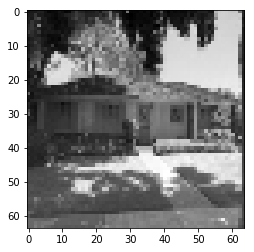

In [397]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

# m = nn.Dropout2d(p=0.2)
# inpu = torch.randn(2, 3, 1, 3)
# print(inpu)
# output = m(inpu)
# print(output)


## Problem 1: Training a Network From Scratch
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 15-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 1,500 original training images as much (because it sees 3,000 training images now, although they're not as good as 3,000 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [398]:
# ==========================================
#       Define Network Architecture
# ==========================================
torch.manual_seed(1)
np.random.seed(1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 15)
        #self.fc2 = nn.Linear(180, 126)
        #self.fc3 = nn.Linear(126, 15)
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        #self.bn_fc = nn.BatchNorm1d(15)
        self.dropout = nn.Dropout2d()

    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         #// Dropout
#         #// batch norm 6 and tanh and pool - BatchNorm2d and 1d
#         x = self.pool(F.relu(self.conv2(x)))
#         #// batch norm 16 and tanh and pool
#         x = x.view(-1, 16 * 13 * 13)
#         x = self.fc1(x)
#         #x = F.relu(self.fc1(x))
#         #x = F.relu(self.fc2(x))
#         #x = self.fc3(x)
        
        #x = self.pool(torch.tanh(self.bn1(self.dropout(self.conv1(x)))))
        #x = self.pool(torch.tanh(self.bn2(self.dropout(self.conv2(x)))))
        x = self.pool(torch.tanh(self.bn1(self.conv1(x))))
        x = self.pool(torch.tanh(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 13 * 13)
        #x = torch.tanh(self.fc1(x))
        x = self.fc1(x)
        #x = torch.tanh(self.fc2(x))    
        #x = self.fc3(x)
        return x

net = Net()

In [399]:
# ==========================================
#         Optimize/Train Network
# ==========================================
import torch.optim as optim

def train_model(model, train_data, criterion, optimizer, n_epoch=30):
    since = time.time()
    #model.train()
    for epoch in range(n_epoch):  # loop over the dataset multiple time
        print('Epoch {}/{}'.format(epoch + 1, n_epoch))
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        for data in train_data:
            # get the inputs
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        data_len = len(train_data) * batch_num
        epoch_loss = running_loss / data_len
        epoch_acc = running_corrects.double() / data_len

        print('Train Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss, epoch_acc * 100))
    #print('Finished Training')
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

# ==========================================
#            Evaluating Network
# ==========================================

def test_model(model, test_data, criterion): 
    since = time.time()
    correct = 0.0
    total = 0
    model.eval()
    
    #with torch.no_grad():
    for data in test_data:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        #correct += (predicted[0] == labels).sum().item()
        correct += torch.sum(predicted == labels.data)

    total_image = len(test_data) * batch_num
    print('Accuracy of the network on the {} test images: {:.0f}%'.format(total_image, 100 * correct.double()/total_image))
    time_elapsed = time.time() - since
    print('Testing completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
num_epoch = 100
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate
net = train_model(net, trainloader_small, criterion, optimizer, n_epoch=num_epoch)

print()
print('Predication of TEST set images...')
test_model(net, testloader_small, criterion)

Epoch 1/100
Train Loss: 2.4817 Acc: 20.9000%
Epoch 2/100
Train Loss: 2.0465 Acc: 35.3667%
Epoch 3/100
Train Loss: 1.8887 Acc: 40.5333%
Epoch 4/100
Train Loss: 1.8113 Acc: 43.4667%
Epoch 5/100
Train Loss: 1.7478 Acc: 45.9667%
Epoch 6/100
Train Loss: 1.6839 Acc: 48.3000%
Epoch 7/100
Train Loss: 1.6111 Acc: 51.4667%
Epoch 8/100
Train Loss: 1.5332 Acc: 54.0000%
Epoch 9/100
Train Loss: 1.4775 Acc: 54.5333%
Epoch 10/100
Train Loss: 1.3905 Acc: 57.3000%
Epoch 11/100
Train Loss: 1.3054 Acc: 60.0667%
Epoch 12/100
Train Loss: 1.2521 Acc: 61.7333%
Epoch 13/100
Train Loss: 1.1700 Acc: 64.0000%
Epoch 14/100
Train Loss: 1.1168 Acc: 65.9667%
Epoch 15/100
Train Loss: 1.0716 Acc: 68.0333%
Epoch 16/100
Train Loss: 1.0273 Acc: 69.6333%
Epoch 17/100
Train Loss: 1.0115 Acc: 70.3000%
Epoch 18/100
Train Loss: 1.0206 Acc: 69.8667%
Epoch 19/100
Train Loss: 1.0065 Acc: 70.3333%
Epoch 20/100
Train Loss: 0.9553 Acc: 73.3000%
Epoch 21/100
Train Loss: 0.8987 Acc: 75.0667%
Epoch 22/100
Train Loss: 0.8677 Acc: 76.366

# Details description of the model and experiments done

## Data Augmentation
Since the training data size is very less, it is better to do data augmentation to increase the training data size. So for every training image we do a horizontal flip and add the image into the training set, so effectively the number of training set images are doubled.

## Data normalization
The images aren't standized/zero-centered. One trick is to subtract the mean from every image. It would be proper to only compute the mean from the training images and testing images. This preprocessing was done during the image read.

## Convolution Neural Network
Designed a simple CNN(Convolution Neural Network) with 2 convolution layers and 3 Fully connected layers. 2 Maxpooling operations are done after the convolutions layer to reduce the dimensions of the data. Stochastic Gradient Descent (SGD) optimizers is used.

### Layer 1 - Conv layer
1st Convolution layer
Input size - (1, 64, 64) - Single channel 32x32 images
6 5x5 kernel filter giving a 6 layer 60x60 output.
On the output a batch normalization layer operation is done, followed by tanh activations.
Followed by a maxpool layer(2x2) is added giving an 6 layers 30x30 output

### Layer 2 - Conv layer
2nd Convolution layer
16 5x5 kernel filter giving a 16 layer 26x26 output.
On the output a batch normalization layer operation is done, followed by tanh activations.
Followed by a maxpool layer(2x2) is added giving an 16 layers 13x13 output

### Layer 3 - Fully Connected layer
1st FC layer
Configuration 1 - In_features - 2704(16* 13* 13) out_features - 180
Configuration 2 - In_features - 2704(16* 13* 13) out_features - 15 (Gives good accuracy)
The above 2 configuration were tried. In configuration 2, this layer was the last layer.

### Layer 4 - Fully Connected layer
2nd FC layer
In_features - 180, out_features - 126
This layer was used only during configuration 1 and not used during configuration 2.

### Layer 5 - Fully Connected layer
3rd FC layer
In_features - 126, out_features - 15
This layer was used only during configuration 1 and not used during configuration 2.

## Network regularization
Network regularization layer (dropout) layers were added for the outputs of covolution layer. The default value for p was selected which is 0.5. Dropout layer are active only during the training phase and not active during the testing phase. These layers solve the overfitting problem of the model. In the current model configuration adding the dropout layers didnt give the best accuracy so it is not included in the final best accuracy model.


## Other optimization experimented
### Activation functions
The activation functions experimented are ReLu and Tanh. Tanh gave better accuracy results in comparison as soon below in the table.

### Rotation of Images
During the data preprocessing as part of the data augmentation to increase the training dataset size, random rotations of the images were done and added to the training dataset. This increased dataset for training didn't any major improvement to the testing accuracy

### Batch normalization
Batch normalization is process where the training data is normalized or standized, so that all values are got to common scale. Basically we subtract the mean from each dataset and divide by standard deviation, hence the running mean and running variance is calculated. All operation are done at batch granularity. The mean and standard-deviation are calculated per-dimension over the mini-batches and γ and β are learnable parameter vectors of size C (where C is the input size)

It is activated only during training of the model and turned 'OFF' during testing of the model.
Tried 2 batch layer after the convulation layers gave good results, however adding a normalizing layer to FC didnt provide good output

### Model architecture modification
The Model with 2 convolation and 1 Fully connected layer performed better than model with 2 convolation, 3 fully connected layers.

---

## Result comparison

| CNN NW layers | Data Augm | Data norm | Learning rate | Activation fun | NW regularize | Batch Normalize | Training Epoch | Accuracy | Training Time | Testing Time |
|:-------------:|:---------:|:---------:|:-------------:|:--------------:|:-------------:|:---------------:|:--------------:|:--------:|:-------------:|:------------:|
| 2 Conv + 3 FC | Flip      | Done      | 0.01          | ReLu           | -             | -               | 30             | 39.13%   | 1m 40s           | 0m 1s           |
| 2 Conv + 3 FC | Flip      | Done      | 0.01          | Tanh           | -             | -               | 30             | 46.66%   | 3m 09s           | 0m 1s           |
| 2 Conv + 1 FC | Flip      | Done      | 0.01          | ReLu           | -             | -               | 30             | 45.40%   | 1m 32s           | 0m 1s           |
| 2 Conv + 1 FC | Flip      | Done      | 0.01          | Tanh           | -             | -               | 30             | 48.04%   | 2m 52s           | 0m 1s           |
| 2 Conv + 3 FC | Flip      | Done      | 0.001         | Tanh           | -             | -               | 90             | 48.13%   | 8m 13s           | 0m 1s           |
| 2 Conv + 1 FC | Flip      | Done      | 0.001         | Tanh           | -             | -               | 90             | 52.00%   | 8m 00s           | 0m 1s           |
| 2 Conv + 1 FC | Flip      | Done      | 0.01          | Tanh           | -             | -               | 90             | 51.00%   | 8m 04s           | 0m 1s           |
| 2 Conv + 1 FC | Flip      | Done      | 0.001         | Tanh           | -             | 2 batch layers  | 90             | 57.00%   | 10m 09s          | 0m 1s           |
| 2 Conv + 1 FC | Flip      | Done      | 0.001         | Tanh           | -             | 3 batch layers  | 90             | 26.00%   | 10m 43s          | 0m 1s           |
| 2 Conv + 1 FC | Flip      | Done      | 0.001         | Tanh           | 1 Dp layer    | 2 batch layers  | 90             | 48.00%   | 9m 52s           | 0m 1s           |
| 2 Conv + 1 FC | Flip      | Done      | 0.001         | Tanh           | 2 Dp layer    | 2 batch layers  | 90             | 43.00%   | 10m 19s          | 0m 1s           |
| 2 Conv + 1 FC | Flip      | Done      | 0.001         | Tanh           | -             | 2 batch layers  | 100            | 59.00%   | 10m 37s          | 0m 1s           |
| 2 Conv + 1 FC | Flip+Rot  | Done      | 0.001         | Tanh           | -             | 2 batch layers  | 100            | 46.00%   | 22m 51s          | 0m 1s           |

All times are measured running the model on local PC --> Mac, 2.3 GHz Intel Core i5, 8 GB RAM, Intel Iris Plus Graphics 640 1536 MB

## Best Accuracy value - 59%
**Model Configuration**
***<br>Model   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;--> 2 Convulation layer + 1 FC layer
<br>Data Augmentation &nbsp;&nbsp;&nbsp;--> Normal + Flipped images
<br>Data Normalization &nbsp;&nbsp;&nbsp;--> Done at each image level
<br>Learning Rate &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;    --> 0.001
<br>Activation Function &nbsp;&nbsp;&nbsp;--> Tanh()
<br>Network regularization (Dropout) --> Not used
<br>Batch Normalization &nbsp;&nbsp;&nbsp;--> 2 layers used after the convolution layers
<br>Number of epoch during training &nbsp;&nbsp;&nbsp;--> 100***
### Training time - 10 mins 37 secs
### Testing time - 1 sec


---
## References used
1. Pytorch Tutorails - https://pytorch.org/tutorials/
2. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
3. https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
4. Pytorch Documentation - https://pytorch.org/docs/stable/nn.html?highlight=batchnorm#batchnorm2d

---
---
---

## Problem 2: Fine Tuning a Pre-Trained Deep Network
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 15 scene database) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>
**DO NOT** turn in the downloaded AlexNet, I will download it myself to test your network.

Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [274]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('data/train/', img_size, batch_num=batch_num, shuffle=True, augment=False, is_color=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('data/test/', img_size, num_per_class=100, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

1500
50
Finish loading 30 minibatches(=50) of training samples.
1500
50
Finish loading 30 minibatches(=50) of testing samples.


In [357]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
import torchvision.models as models
from torchvision import datasets, transforms
import time
import os

out_classes = 15
n_epoch = 30
fine_tune = True

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders:
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                # Get model outputs and calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        #if epoch_acc > best_acc:
        #    best_acc = epoch_acc

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    return model

def test_model(model, dataloaders, criterion):
    since = time.time()
    i = 0
    
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0.0

    # Iterate over data.
    for inputs, labels in dataloaders:
        i = i + 1
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if i % 10 == 0:
            print('Prediction of {} images done'.format(i*batch_num))

    epoch_loss = running_loss / len(dataloaders.dataset)
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)

    print('TEST Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc * 100))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(epoch_acc))

    return model

def initialize_model():
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = models.alexnet(pretrained=True)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, out_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model()

# Print the model we just instantiated
print(model_ft) 

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets_train = datasets.ImageFolder('data/train', data_transforms['train'])
# Create training and validation dataloaders
#dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_num, shuffle=True, num_workers=4) for x in ['train']}
dataloaders_train = torch.utils.data.DataLoader(image_datasets_train, batch_size=batch_num, shuffle=True, num_workers=4)

# Create training and validation datasets
image_datasets_test = datasets.ImageFolder('data/test', data_transforms['test'])
# Create training and validation dataloaders
dataloaders_test = torch.utils.data.DataLoader(image_datasets_test, batch_size=batch_num, shuffle=True, num_workers=4)

print('Number of training images batches -> {}'.format(len(dataloaders_train)))
print('Number of test images batches -> {}'.format(len(dataloaders_test)))

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
#alexnet = models.alexnet(pretrained=True)

criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = train_model(model_ft, dataloaders_train, criterion, optimizer_ft, num_epochs=n_epoch)

print()
print('Predication of TEST set images...')
model_ft = test_model(model_ft, dataloaders_test, criterion)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

# ALEXNET

## Details description of the model and experiments done
Alexnet is a popular network introduced in the paper 

**"ImageNet Classification with Deep Convolutional Neural Networks"**

Authored by 
- Alex Krizhevsky - University of Toronto - kriz@cs.utoronto.ca
- Ilya Sutskever - University of Toronto - ilya@cs.utoronto.ca
- Geoffrey E. Hinton - University of Toronto - hinton@cs.utoronto.ca

[Download](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

In this HW we use a pretrained Alexnet model from pytorch model zoo and do fine tuning by changing the last fully connected layer to output 15 classes as per input image classes. Since the last layer is changed, we retrain the AlexNet using the training images to update the weight before running the testing images for prediction. 
**Training is done for 30 epochs**
The dumps show the training loss and accuracy at each epoch.
**Stochastic Gradient Descent** optimizer is used with learning rate set to 0.001

Please find below details of the AlexNet layer configurations.

### AlexNet Layer configuration
AlexNet has 5 convolution layers and 3 fully connected layers along with few maxpooling layers and few dropout layers.

### Layer 1 - Conv layer & Maxpool
The 1st Convolution layer  => input size => (3, 224, 224)
64 11x11 filter with stride=(4,4) and padding=(2,2)
This is followed by an inplace ReLU activation and maxpool layer with kernel=3 and stride=2
This layer is not modified compared to the base AlexNet implementation.

### Layer 2 - Conv layer & Maxpool 
The 2nd Convolution layer
192 5x5 filter with stride=(1,1) and padding=(2,2)
This is followed by an inplace ReLU activation and maxpool layer with kernel=3 and stride=2
This layer is not modified compared to the base AlexNet implementation.

### Layer 3 - Conv layer
The 3rd Convoluation layer
384 3x3 filter with stride=(1,1) and padding=(1,1)
This is followed by an inplace ReLU activation
This layer is not modified compared to the base AlexNet implementation.

### Layer 4 - Conv layer
The 4th Convoluation layer
256 3x3 filter with stride=(1,1) and padding=(1,1)
This is followed by an inplace ReLU activation
This layer is not modified compared to the base AlexNet implementation.

### Layer 5 - Conv layer
The 5th Convoluation layer
256 3x3 filter with stride=(1,1) and padding=(1,1)
This is followed by an inplace ReLU activation and maxpool layer with kernel=3 and stride=2
This layer is not modified compared to the base AlexNet implementation.

### Layer 6 - Fully Connected layer
The 1st Fully Connected layer with in-features=9216 and out-features=4096 and with bias being true.
Before this layer a Dropout is added with probability of 0.5.
Also an inplace ReLU activation is done.
This layer is not modified compared to the base AlexNet implementation.

### Layer 7 - Fully Connected layer
The 2nd Fully Connected layer with in-features=4096 and out-features=4096 and with bias being true.
Before this layer a Dropout is added with probability of 0.5.
Also an inplace ReLU activation is done.
This layer is not modified compared to the base AlexNet implementation.

### Layer 8 - Fully Connected layer (modified)
The 3rd Fully Connected layer with in-features=4096 and out-features=15(modified - original 1000) and with bias being true.
This **layer is modified** compared to the base AlexNet implementation, inorder to get the required number of out_classess which is 15 in the current dataset.
This layer provides 15 output classes as prediction, of which the top #1 is consider as the predicted label for the input image. This is NO activation function used in this layer.


---

## Result

| AlexNet NW layers | Train img count | Test img count | Learning rate | Training Epoch | Accuracy  | Training Time | Testing Time |
|:-----------------:|:---------------:|:--------------:|:-------------:|:--------------:|:---------:|:-------------:|:------------:|
| 5 Conv + 3 FC     | 1500            | 3000           | 0.001         | 30 Epoch       | 86.46%    | 72m 48s       | 49s          | 

All times are measured running the model on local PC --> Mac, 2.3 GHz Intel Core i5, 8 GB RAM, Intel Iris Plus Graphics 640 1536 MB

## Accuracy - 86.46%
### Training time - 72 mins 48 secs
### Testing time - 49 secs

---
## References used
1. Pytorch Tutorails - https://pytorch.org/tutorials/
2. Pytorch Documentation - https://pytorch.org/docs/stable/nn.html?highlight=batchnorm#batchnorm2d
3. https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
4. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
5. https://www.cc.gatech.edu/~hays/papers/deep_geo.pdf
6. https://pytorch.org/docs/master/torchvision/models.html
7. http://vision03.csail.mit.edu/cnn_art/index.html
8. https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html
9. http://www.cs.toronto.edu/~tang/papers/dlsvm.pdf
10. Paper - Learning Deep Features for One-Class Classification - https://arxiv.org/pdf/1801.05365.pdf

---
---
---

<!--Write your report here in markdown or html-->
